# Tarea 1: Homología Persistente

La siguiente actividad te ayudará a fortalecer los conceptos de homología persistente y filtraciones, y las paqueterías:
* `gudhi`
* `ripser`
* `giotto-tda`
* `scikit-tda`
* `tadasets`

La actividad está dividida en dos partes:

1. **Ejercicios de Práctica**: En esta sección se te proporcionarán ejercicios prácticos para que puedas aplicar los conceptos aprendidos en la teoría usando las paqueterías mencionadas.
2. **Caso Práctico:** Aplicar el concepto de homología persistente (diagramas, barcodes, imágenes de persistencia, distancias entre Diagramas) a un conjunto de datos reales. En esta sección se te proporcionará un conjunto de datos y se te pedirá que apliques los conceptos aprendidos para analizarlo y extraer información relevante.

## 1. Ejercicios de Práctica

En la siguiente sección se te proporcionarán ejercicios prácticos para que puedas:

- Construir filtraciones de bases de datos y graficarlas.
- Construir los diagramas de persistencia de bases de datos, interpretarlas.
- Construir otras visualizaciones de los diagramas de persistencia.
- Comparar diagramas de persistencia utilizando distancias Bottleneck y Wasserstein, e interpretarlas.

### Ejercicio 1.1:

Utilizando una nube de puntos construidos con la paquetería `tadasets` por cada tipo en la paquetería  (escoge la dimensión, radio, número de puntos, ruido, etc). Con ayuda de la paquetería `gudhi` construye tres filtraciones (variando el `max_edge_length` y que al menos una filtración corresponda a `max_edge_length`= diámetro del conjunto) de la nube de puntos y grafícalas.

### Ejercicio 1.2:

Con lo anterior, toma la filtración asociada a `max_edge_length`=diámetro y grafica el diagrama de persistencia.

### Ejercicio 1.3:

Modifica la visualización de los diagramas de persistencia a:
- Barcode
- Density Plot
- Image of Persistence (necesita `giotto-tda`)
- Persistence Landscape (necesita `giotto-tda`)

### Ejercicio 1.4:

Selecciona dos tipos de nubes de puntos y construye sus diagramas de persistencia para dos filtraciones diferentes (parametro `max_edge_length`). Compara los diagramas de persistencia utilizando las distancias Bottleneck y Wasserstein.

Una vez comparado, ¿qué pasa si modificamos el parámetro noise en la generación de los datos? Para esto, utiliza un mismo tipo de nube de puntos y varía el parámetro `noise` en la función `tadasets.make_*`. Compara los diagramas de persistencia utilizando las distancias Bottleneck y Wasserstein. ¿Qué observas? ¿Qué tipo de ruido afecta más a la homología persistente? ¿Por qué?

## 2. Caso Práctico:


### Ejercicio 2.1
Con las siguientes bases de datos, aplica los conceptos de homología persistente (diagramas, barcodes, imágenes de persistencia, distancias entre Diagramas) para inferir su forma. Una vez hecho tu análisis, proporciona cuales son las características que observaste en cada una de las bases de datos.



### Ejercicio 2.2: Caídas en la Bolsa de Valores

Utilizaremos la homología persistente y la distancia de Wassertein para determinar años en los que la bolsa de valores tuvo un comportamiento atípico (caída).

In [2]:
!pip install ripser persim

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 4.6 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=4a03fb927442630ce1f7a00fb45344890eb729d3aa1ae3f2bbb48f6e3290c68c
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


In [3]:
import numpy as np
import yfinance as yf
from ripser import ripser
from persim import plot_diagrams, wasserstein
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Obtenemos los datos, que pertenecen a una serie de tiempo, y las convertimos en una nube de puntos utilizando un encaje.

In [4]:
def fetch_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)['Close']
    log_returns = np.log(data[1:].values / data[:-1].values)  # Calculate log-returns
    return log_returns, data.index[1:]

In [5]:
def embed_time_series(data, delay, dim):
    n_points = len(data) - (dim - 1) * delay
    if n_points <= 0:
        raise ValueError("Embedding parameters (delay, dim) result in insufficient points.")
    embedded = np.zeros((n_points, dim))  # Initialize an empty array with the correct dimensions
    for i in range(dim):
        # Flatten data before assigning to embedded[:, i]
        embedded[:, i] = data[i * delay:i * delay + n_points].flatten()
    return embedded

Crea una función que calcule los diagramas de persistencia dado un conjunto de datos (dataframe o numpy) variable. Puedes ayudarte de las paqueterías `ripser`. La función debe tener:

Inputs:
- `data`: dataframe o numpy array con los datos a analizar

Outputs:
- `diagrams`: lista de diagramas de persistencia



### Función para calcular diagramas de persistencia

In [7]:
def compute_persistence_diagrams(data):
    if hasattr(data, "values"):  # Si es DataFrame, se convierte a numpy array
        data = data.values

    diagrams = ripser(data)['dgms']
    return diagrams


Crea una función que calcule la distancia de Wasserstein entre dos diagramas de persistencia asociados a ventanas de encaje distinto. La función debe tener:

Inputs:
- `data`: dataframe o numpy array con los datos a analizar.
- `window_size`: tamaño de la ventana de encaje.
- `delay`: espaciamiento entre observaciones para el encaje.
- `dim`: dimensión en la que se va a encajar.

Output:
- `distance`: distancia de Wasserstein entre los diagramas de persistencia.


### Funcion para calcular distancia de Wasserstein

In [6]:
def wasserstein_distance_between_windows(data, window_size, delay, dim):
    #if hasattr(data, "values"):  # Convertimos DataFrame a numpy array si es necesario
        #data = data.values

    if len(data) < 2 * window_size:
        raise ValueError("La longitud de los datos debe ser al menos el doble del tamaño de la ventana.")

    # Dividir en dos ventanas
    window1 = data[:window_size]
    window2 = data[window_size:2*window_size]

    # Encajar ambas ventanas
    embedded1 = embed_time_series(window1, delay, dim)
    embedded2 = embed_time_series(window2, delay, dim)

    # Calcular diagramas
    diag1 = compute_persistence_diagrams(embedded1)
    diag2 = compute_persistence_diagrams(embedded2)

    # Usamos la dimensión H1 (bucles)
    distance = wasserstein(diag1[1], diag2[1])

    return distance

### Funciones preexistentes

In [8]:
def visualize_embedding_3d(embedded_data, delay, title="3D Time Delay Embedding"):
    """
    Visualize a 3D time delay embedding.

    Parameters:
        embedded_data (np.array): The embedded data with shape (n_points, 3).
        delay (int): The time delay used for the embedding.
        title (str): Title of the plot.
    """
    # Create a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the embedded data
    ax.plot(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2], 'b-', linewidth=0.5, label='Embedding Curve')
    ax.scatter(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2], c='r', s=10, label='Data Points')

    # Add labels and title
    ax.set_title(title)
    ax.set_xlabel("x(t)")
    ax.set_ylabel(f"x(t + {delay})")
    ax.set_zlabel(f"x(t + {2 * delay})")

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()

In [9]:
def visualize_results(log_returns, dates, wasserstein_distances, window_dates):
    # Plot time series completa
    plt.figure(figsize=(14, 6))

    # Subplot 1: Log-retornos
    plt.subplot(2, 1, 1)
    plt.plot(dates, log_returns, label="Log Returns", color="blue")
    plt.title("Time Series (Log Returns)")
    plt.xlabel("Date")
    plt.ylabel("Log Returns")
    plt.legend()
    plt.grid()

    # Subplot 2: Distancia de Wasserstein
    plt.subplot(2, 1, 2)
    plt.plot(window_dates, wasserstein_distances, label="Wasserstein Distance", color="orange")
    plt.title("Wasserstein Distance Evolution")
    plt.xlabel("Date")
    plt.ylabel("Wasserstein Distance")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


Utiliza las funciones anteriores para visualizar el encaje de los datos y la distancia de Wasserstein entre los diagramas de persistencia. Puedes graficar la distancia de Wasserstein en función del tiempo para observar si hay caídas en la bolsa de valores.

Utiliza los siguientes parámetros para tu análisis:

```python
ticker = "AAPL"  # Example stock ticker (Apple Inc.)
start_date = "2015-01-01"
end_date = "2022-01-01"
window_size = 100  # Number of data points in each sliding window
delay = 2
dim = 3
```

Prueba con otro ticker de tu elección y determina si hay caídas en la bolsa de valores.

### Ejecución de Función de Distancia

**Parametros Iniciales**

In [13]:
# Parámetros del análisis
ticker = "AAPL"  # Example stock ticker (Apple Inc.)
start_date = "2015-01-01"
end_date = "2022-01-01"
window_size = 100 # Number of data points in each sliding window
delay = 2
dim = 3

# Obtener log-retornos
log_returns, dates = fetch_data(ticker, start=start_date, end=end_date)

# Calcular una distancia entre 2 ventanas consecutivas
distance = wasserstein_distance_between_windows(log_returns, window_size, delay, dim)
print(f" Distancia de Wasserstein entre las dos primeras ventanas: {distance:.4f}")


[*********************100%***********************]  1 of 1 completed

 Distancia de Wasserstein entre las dos primeras ventanas: 0.0345


**Prueba con otro ticker (Amazon)**

In [20]:
# Parámetros del análisis
ticker = "AMZN"  # Ticker de Amazon
start_date = "2015-01-01"
end_date = "2022-01-01"
window_size = 100 # Number of data points in each sliding window
delay = 2
dim = 3

# Obtener log-retornos
log_returns_amzn, dates_amzn = fetch_data(ticker, start=start_date, end=end_date)

# Calcular una distancia entre 2 ventanas consecutivas
distance = wasserstein_distance_between_windows(log_returns_amzn, window_size, delay, dim)
print(f" Distancia de Wasserstein entre las dos primeras ventanas: {distance:.4f}")

[*********************100%***********************]  1 of 1 completed

 Distancia de Wasserstein entre las dos primeras ventanas: 0.0530


## Visualizar Distancias

In [21]:
# Calcular distancias de Wasserstein entre muchas ventanas
wasserstein_distances = []
window_dates = []

def compute_wasserstein_series(log_returns, dates, window_size, delay, dim, step=1):
    wasserstein_distances = []
    window_dates = []

    for i in range(0, len(log_returns) - 2 * window_size + 1, step):
        data_slice = log_returns[i:i + 2 * window_size]
        try:
            dist = wasserstein_distance_between_windows(data_slice, window_size, delay, dim)
            wasserstein_distances.append(dist)
            window_dates.append(dates[i + window_size])
        except ValueError:
            continue

    return wasserstein_distances, window_dates

### Distancias Apple

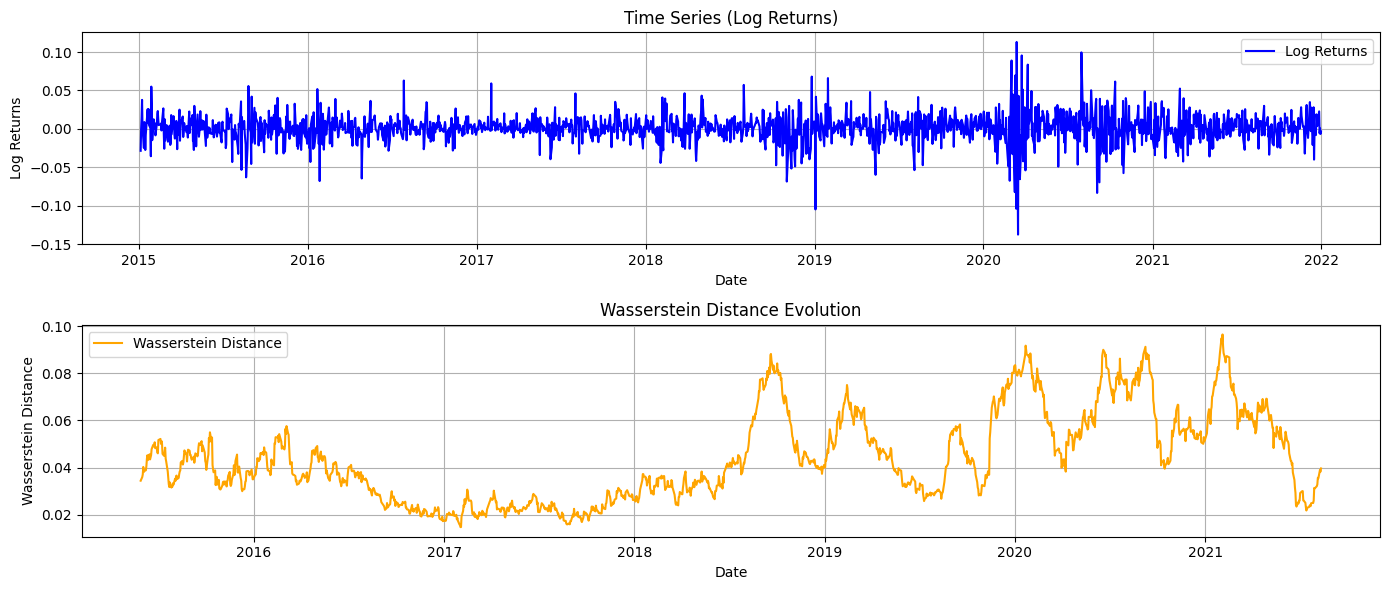

In [24]:
wasserstein_distances, window_dates = compute_wasserstein_series(
    log_returns, dates, window_size, delay, dim, step=1
)

# Visualizar resultados
visualize_results(log_returns, dates, wasserstein_distances, window_dates)

### Distancias Amazon

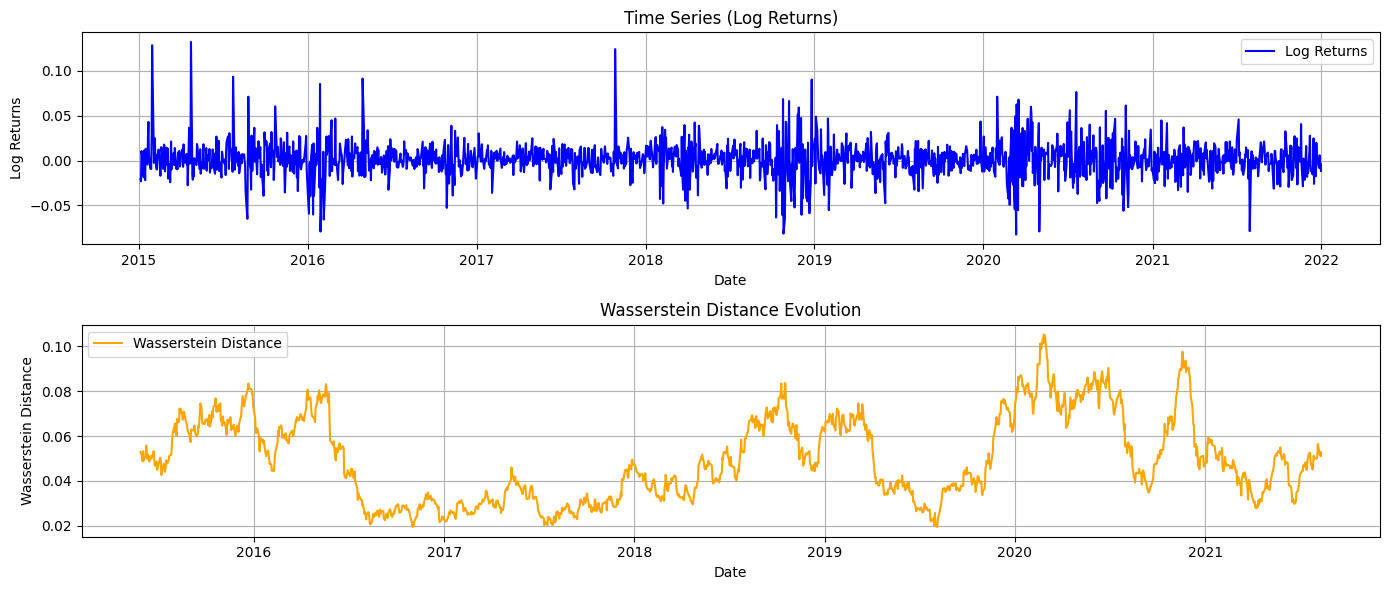

In [23]:
wasserstein_distances, window_dates = compute_wasserstein_series(
    log_returns_amzn, dates_amzn, window_size, delay, dim, step=1
)

# Visualizar resultados
visualize_results(log_returns_amzn, dates_amzn, wasserstein_distances, window_dates)


## Encaje en una fecha específica

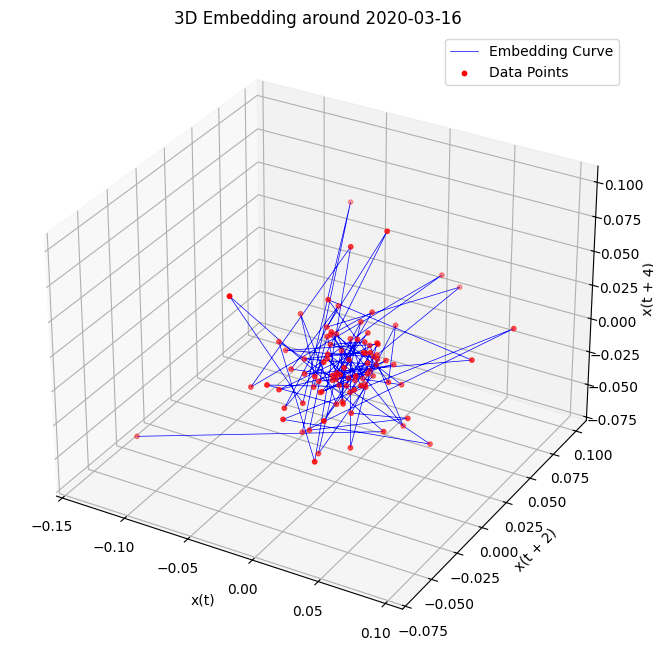

In [25]:
# Escoger una fecha de interés (como una caída en 2020)
fecha_interes = '2020-03-16'  # Cerca de la caída por COVID
if fecha_interes in dates.astype(str):
    index = list(dates).index(np.datetime64(fecha_interes))
    window_data = log_returns[index:index + window_size]
    embedded = embed_time_series(window_data, delay, dim)
    visualize_embedding_3d(embedded, delay, title=f"3D Embedding around {fecha_interes}")
else:
    print(f"La fecha {fecha_interes} no se encuentra en el rango de datos.")
